In [1]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor

from dct_autoencoder import (
    DCTAutoencoder,
    DCTBasis,
    get_dct_basis,
)
from dct_autoencoder.visualization import visualize_dct_basis_functions

In [2]:
torch.backends.mps.is_built(), torch.backends.mps.is_available()

(True, True)

## Basis

dct_basis.basis_functions.shape=torch.Size([8, 8, 8, 8])
dct_basis.spatial_frequencies_components.shape=torch.Size([8, 8, 2])
dct_basis.spatial_frequencies_magnitude.shape=torch.Size([8, 8])
dct_basis.multiplication_factor_matrix.shape=torch.Size([8, 8])
dct_basis.multiplication_factor_scalar=0.25
dct_basis.block_size=8


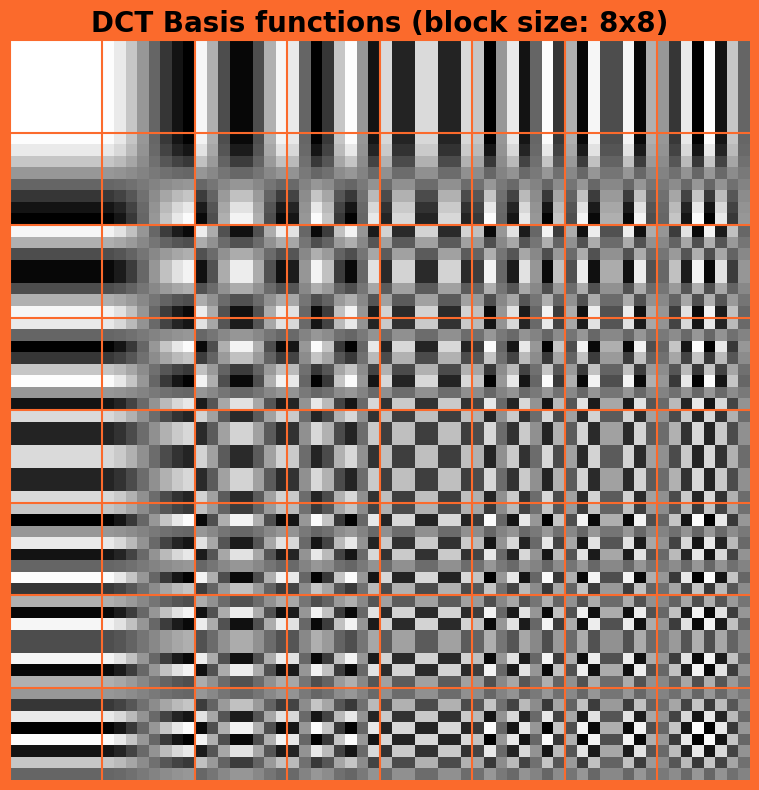

In [3]:
dct_basis: DCTBasis = get_dct_basis(block_size=8)
print(f"{dct_basis.basis_functions.shape=}")
print(f"{dct_basis.spatial_frequencies_components.shape=}")
print(f"{dct_basis.spatial_frequencies_magnitude.shape=}")
print(f"{dct_basis.multiplication_factor_matrix.shape=}")
print(f"{dct_basis.multiplication_factor_scalar=}")
print(f"{dct_basis.block_size=}")
fig, ax = visualize_dct_basis_functions(dct_basis)
plt.show()

## DCTAutoEncoder

In [4]:
block_size = 8
luminance_compression_ratio: float = 1 / 2
chrominance_compression_ratio: float = 1 / 4
dct_autoencoder = DCTAutoencoder(
    block_size=block_size,
    luminance_compression_ratio=luminance_compression_ratio,
    chrominance_compression_ratio=chrominance_compression_ratio,
)
isinstance(dct_autoencoder, torch.nn.Module)

/Users/yaroslav/Sources/dct-autoencoder/dct_autoencoder/core.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("kernels", torch.tensor(kernels))
/Users/yaroslav/Sources/dct-autoencoder/dct_autoencoder/core.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(spatial_frequencies_magnitude, dtype=torch.float32),
/Users/yaroslav/Sources/dct-autoencoder/dct_autoencoder/core.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(spatial_frequencies_components, dtype=torch.int),
/Users/yaroslav/So

True

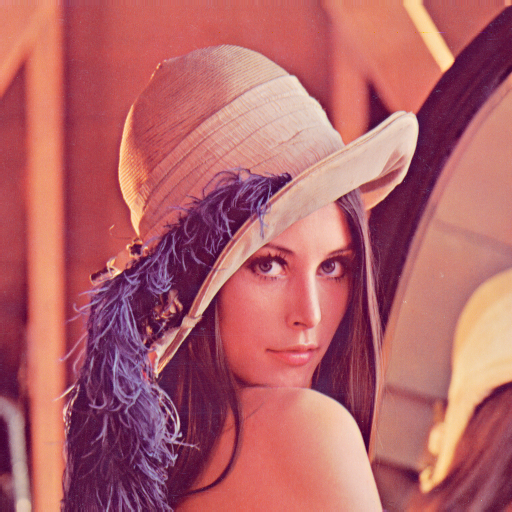

In [5]:
image = Image.open("assets/test_images/Lenna_(test_image).png")
image

In [6]:
for name, param in dct_autoencoder.named_parameters():
    print(f"Parameter: {name}, Type: {param.dtype}")

for name, buffer in dct_autoencoder.named_buffers():
    print(f"Buffer: {name}, Type: {buffer.dtype}")

Buffer: kernels, Type: torch.float32
Buffer: spatial_frequencies_magnitude, Type: torch.float32
Buffer: spatial_frequencies_components, Type: torch.int32
Buffer: block_size, Type: torch.int32
Buffer: multiplication_factor_scalar, Type: torch.float32
Buffer: multiplication_factor_matrix, Type: torch.float32


In [7]:
for name, param in dct_autoencoder.named_parameters():
    print(f"Parameter: {name}, Device: {param.device}")

for name, buffer in dct_autoencoder.named_buffers():
    print(f"Buffer: {name}, Device: {buffer.device}")

Buffer: kernels, Device: cpu
Buffer: spatial_frequencies_magnitude, Device: cpu
Buffer: spatial_frequencies_components, Device: cpu
Buffer: block_size, Device: cpu
Buffer: multiplication_factor_scalar, Device: cpu
Buffer: multiplication_factor_matrix, Device: cpu


### Encoding

In [9]:
device = torch.device("mps")
dct_autoencoder.to(device)
image_tensor = to_tensor(image)
print(f"{image_tensor.shape=}")
batch = image_tensor.unsqueeze(0).to(device)
dct_encodings = dct_autoencoder.encode(batch)
print(f"{dct_encodings.shape=}")

image_tensor.shape=torch.Size([3, 512, 512])
dct_encodings.shape=torch.Size([1, 192, 64, 64])


In [13]:
%timeit dct_encodings = dct_autoencoder.encode(batch)

1.96 ms ± 138 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
device = torch.device("cpu")
dct_autoencoder.to(device)
image_tensor = to_tensor(image)
print(f"{image_tensor.shape=}")
batch = image_tensor.unsqueeze(0).to(device)
dct_encodings = dct_autoencoder.encode(batch)
print(f"{dct_encodings.shape=}")

image_tensor.shape=torch.Size([3, 512, 512])
dct_encodings.shape=torch.Size([1, 192, 64, 64])


### Decoding

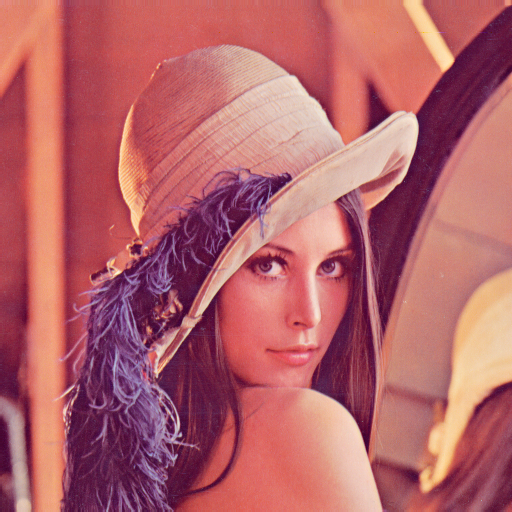

In [14]:
reconstructed_batch = dct_autoencoder.decode(dct_encodings)
reconstructed_image = reconstructed_batch.squeeze(0)
torch.testing.assert_close(batch, reconstructed_batch, rtol=1e-3, atol=1e-3)
to_pil_image(reconstructed_image)

### Compress

In [15]:
compressed_dct_encodings = dct_autoencoder.compress(dct_encodings)
print(f"{compressed_dct_encodings.shape=}")
compression_ratio = dct_encodings.numel() / compressed_dct_encodings.numel()
print(f"{compression_ratio=}")

compressed_dct_encodings.shape=torch.Size([1, 24, 64, 64])
compression_ratio=8.0


## Decompress

decompressed_dct_encodings.shape=torch.Size([1, 192, 64, 64])


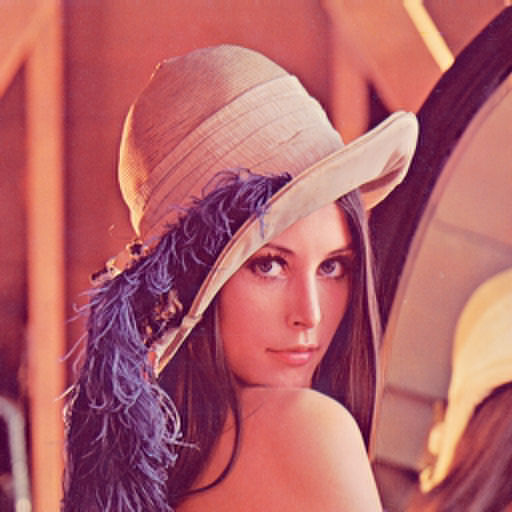

In [16]:
decompressed_dct_encodings = dct_autoencoder.decompress(compressed_dct_encodings)
print(f"{decompressed_dct_encodings.shape=}")
decompressed_batch = dct_autoencoder.decode(decompressed_dct_encodings)
decompressed_image = decompressed_batch.squeeze(0)
to_pil_image(decompressed_image)